In [15]:
import keras
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

def load_trace_dataset(purpose='categorical', ttype='test'):
    suffix = "{0}_{1}.pickled".format(purpose, ttype)
    p = data_path.replace(".xes", suffix)
    return pickle.load(open(p, "rb"))

def calculate_standard_percentile_precisions(model, input_batches, output_batches, input_shape, percentile_steps = 10):
    percentile_matches  = [0] * percentile_steps
    percentile_elements = [0] * percentile_steps

    for x,y in zip(input_batches, output_batches):
        y_hat = model.predict(x.reshape(input_shape))[0]
        current_percentile = 1
        percentile_step = len(x) / percentile_steps

        # loop through predicted next steps and compare
        for i in range(0,len(y)):
            if i > (current_percentile * percentile_step):
                current_percentile += 1

            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                 # 0-based indexing, this is actually the 1st percentile
                percentile_matches[current_percentile -1] += 1
            percentile_elements[current_percentile -1] += 1

    return [p_m / p_t for p_m,p_t in zip(percentile_matches,percentile_elements)]

def calculate_bipartite_percentile_precisions(model, input_batches, sec_input_batches, output_batches, input_shape, sec_input_shape, percentile_steps = 10):
    percentile_matches  = [0] * percentile_steps
    percentile_elements = [0] * percentile_steps

    for x1,x2,y in zip(input_batches, sec_input_batches, output_batches):
        x1 = x1.reshape(input_shape)
        x2 = x2.reshape(sec_input_shape)
        y_hat = model.predict({'seq_input': x1, 'sec_input': x2})[0]
        
        current_percentile = 1
        percentile_step = len(y) / percentile_steps

        # loop through predicted next steps and compare
        for i in range(0,len(y)):
            if i > (current_percentile * percentile_step):
                current_percentile += 1

            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                 # 0-based indexing, this is actually the 1st percentile
                percentile_matches[current_percentile -1] += 1
            percentile_elements[current_percentile -1] += 1

    return [p_m / p_t for p_m,p_t in zip(percentile_matches,percentile_elements)]

##### CONFIGURATION SETUP ####
data_path = "../logs/bpic2011/normalized/.xes"
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
target_variable = "concept:name"
percentiles = 20
### CONFIGURATION SETUP END ###

test_traces_categorical = load_trace_dataset('categorical', 'test')
test_traces_ordinal = load_trace_dataset('ordinal', 'test')
test_traces_sp2 = load_trace_dataset('sp2', 'test')
test_targets = load_trace_dataset('target', 'test')

feature_dict = load_trace_dataset('mapping', 'dict')

# Evermann performance evaluation

In [31]:
evermann_test_traces    = [ t[target_variable].map(feature_dict[target_variable]['to_int']).values for t in test_traces_categorical ]
evermann_input_batches  = np.array([ t.reshape((-1,1)) for t in evermann_test_traces ])
evermann_target_batches = np.array([ t.values.reshape((-1,625)) for t in test_targets])

In [30]:
# load the most recently learned model
evermann_model = keras.models.load_model("../../docker_share/evermann/evermann_baseline_e44_acc18.700.h5")

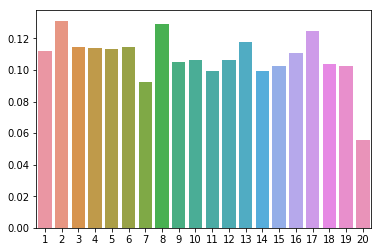

In [34]:
percentile_precisions = calculate_standard_percentile_precisions(evermann_model,
                                                                 evermann_input_batches,
                                                                 evermann_target_batches,
                                                                 input_shape=(1,-1,1),
                                                                 percentile_steps = percentiles)
sns.barplot(x=list(range(1,percentiles+1)), y=percentile_precisions)

# Schönig performance evaluation

In [2]:
schoenig_test_traces = [None] * len(test_traces_categorical)

# Use one-hot encoding for categorical values
for col in test_traces_categorical[0].columns:
    nc = len(feature_dict[col]['to_int'].values())
    for i in range(0, len(test_traces_categorical)):
        tmp = test_traces_categorical[i][col].map(feature_dict[col]['to_int'])
        tmp = keras.utils.to_categorical(tmp, num_classes=nc)
        tmp = pd.DataFrame(tmp).add_prefix(col)

        schoenig_test_traces[i] = pd.concat([schoenig_test_traces[i], tmp], axis=1)

# tie everything together since we only have a single input layer
schoenig_test_traces = [ pd.concat([a,b], axis=1) for a,b in zip(test_traces_ordinal, schoenig_test_traces)]
n_train_cols  = len(schoenig_test_traces[0].columns)
n_target_cols = len(test_targets[0].columns)

schoenig_input_batches  = np.array([ t.values.reshape((-1,n_train_cols))  for t in schoenig_test_traces ])
schoenig_target_batches = np.array([ t.values.reshape((-1,n_target_cols)) for t in test_targets])

In [18]:
# load the most recently learned model
schoenig_model = keras.models.load_model("../../docker_share/schoenig/grouped/best_val_loss_e5.hdf5")

In [ ]:
percentile_precisions = calculate_standard_percentile_precisions(schoenig_model,
                                                                 schoenig_input_batches,
                                                                 schoenig_target_batches,
                                                                 input_shape=(1,-1,n_train_cols),
                                                                 percentile_steps = percentiles)
sns.barplot(x=list(range(1,percentiles+1)), y=percentile_precisions)

# Schönig feature importance evaluation

In [90]:
# sklearn is (not yet?) able to permute 3-D input or 2-D input. Thus
def generate_score_function(model, input_shape):
    def score_model(x, y):
        t_acc = 0
        y_hat = model.predict(x.reshape(input_shape))[0]

        for i in range(0,len(y)): # loop through predicted next steps and compare
            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                t_acc += 1

        return t_acc / len(x)
    return score_model

n_tests = 10#len(schoenig_input_batches)
base_scores = [None] * n_tests
score_decreases = [None] * n_tests
feature_importances = [None] * n_tests

for i in range(0, n_tests):
    base_scores[i], score_decreases[i] = get_score_importances(generate_score_function(schoenig_model,
                                                                            (1,-1,n_train_cols)),
                                                    schoenig_input_batches[i],
                                                    schoenig_target_batches[i])
    feature_importances[i] = np.mean(score_decreases[i], axis=0)

In [ ]:
sum(feature_importances) / n_tests

# Schönig training performance curve

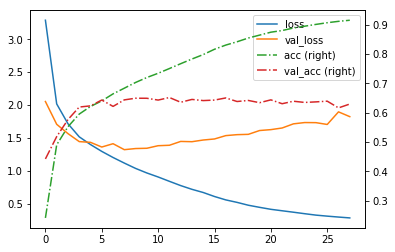

In [17]:
train_stats = pd.read_pickle('/home/felix.wolff2/docker_share/schoenig/grouped/train_statistics.pickled')
train_stats[['loss', 'val_loss','acc', 'val_acc']][0:60].plot(secondary_y=['acc', 'val_acc'], kind='line', style=['-','-','-.','-.'])

# SP2 performance evaluation

In [5]:
# load the most recently learned model
sp2_model = keras.models.load_model("../../docker_share/sp2/grouped/best_val_loss_e38.hdf5")

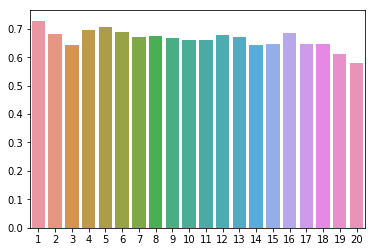

In [16]:
n_sp2_cols = len(test_traces_sp2[0].columns)
test_traces_sp2 = [ t.values for t in test_traces_sp2 ]
percentile_precisions = calculate_bipartite_percentile_precisions(sp2_model,
                                                                  schoenig_input_batches,
                                                                  test_traces_sp2,
                                                                  schoenig_target_batches,
                                                                  input_shape=(1,-1,n_train_cols),
                                                                  sec_input_shape=(1,-1,n_sp2_cols),
                                                                  percentile_steps = percentiles)
sns.barplot(x=list(range(1,percentiles+1)), y=percentile_precisions)

# SP2 training performance curve

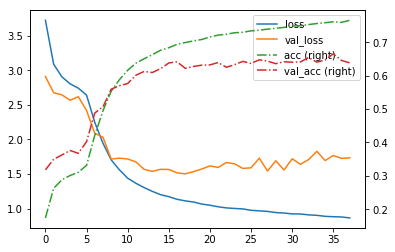

In [7]:
train_stats = pd.read_pickle('/home/felix.wolff2/docker_share/sp2/grouped/train_statistics.pickled')

train_stats[['loss', 'val_loss','acc', 'val_acc']][0:60].plot(secondary_y=['acc', 'val_acc'], kind='line', style=['-','-','-.','-.'])
# train_stats[['acc', 'val_acc']].plot(secondary_y=True, style='g')